In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Além da Regressão Linear

Assim como os métodos de classificação tem como ponto de partida a regressão logística, os **regressores** tem como ponto de partida a regressão linear.

No entanto, a regressão linear é inadequada em muitas situações. Vamos ver alguns motivos pelas quais uma regressão linear pode ser uma escolha inadequada para resolver nosso problema:

1. **Colinearidade** muitas vezes as variáveis de entrada do nosso modelo apresentam correlações entre si. Podemos extender esse conceito e *imaginar um dataset onde as variáveis de entrada são, em si, resultados de outros modelos*.
1. **Função não-linear desconhecida**: Vimos que mesmo sendo *linear* uma regressão pode representar relações mais complexas através da transformação de variáveis. No entanto, isso parte do pressuposto que conhecemos, ou que pelo menos conseguimos descobrir, qual a função que liga cada uma de nossas variáveis de entrada à variável resposta.

Hoje veremos alguns métodos para tratar essas duas questões - primeiro extendendo o modelo da regressão e depois através dos algoritmos de Machine Learning.

## Dataset

Na aula de hoje utilizaremos o dataset `Ames Housing Dataset`, obtido através do Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Este dataset é uma extensão e atualização dos dados de uma tabela muito utilizada na construção e validação de métodos estatísticos, o Boston Housing Dataset.

O dataset completo compreende 81 variáveis, e a tarefa é, utilizando parte dessas variáveis, estimar o preço de venda de imóveis.  Os dados da tabela foram coletados entre 2006 e 2010 na cidade de Ames em Iowa-EUA a partir da venda de imóveis. Nosso objetivo será construir um modelo que a partir das caracteristicas da casa e sua localização seja capaz de prever o preço pelo qual esta foi vendida!

In [107]:
tb_housing = pd.read_csv("data/tb_ames_housing.csv")


In [4]:
tb_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Uma boa parte das variáveis presentes são variáveis categóricas. Para aula de hoje focaremos na análise das variáveis continuas, simplificando a análise do resultado dos modelos. Primeiro, vamos mapear quais colunas são numéricas e, destas, quais contém variáveis explanatórias (removendo IDs, variáveis relativas à data e variáveis categóricas codificadas como número).

In [7]:
tb_housing.select_dtypes(include="number").columns


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Antes de excluir as variáveis de data vamos calcular a idade do imóvel no momento da venda através do tempo entre a última reforma (ou construção do imóvel) e a data de venda.

In [8]:
tb_housing["age_when_sold"] = tb_housing["YrSold"] - tb_housing["YearRemodAdd"]


In [9]:
col_exclude = [
    "Id",
    "MSSubClass",
    "MoSold",
    "YrSold",
    "GarageYrBlt",
    "YearBuilt",
    "YearRemodAdd",
]
tb_housing_num = (
    tb_housing.select_dtypes(include=[np.number])
    .drop(col_exclude, axis=1)
    .dropna()
    .copy()
)


Agora vamos separar selecionar nossas variáveis de entrada (escolhendo-as através da lista x_vars) e separar nossos dados em train e test para termos boas estimativas do erro de cada modelo construído.

In [10]:
x_vars = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "age_when_sold",
]
X_train, X_test, y_train, y_test = train_test_split(
    tb_housing_num[x_vars], tb_housing_num["SalePrice"], test_size=0.2
)
scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

<AxesSubplot:>

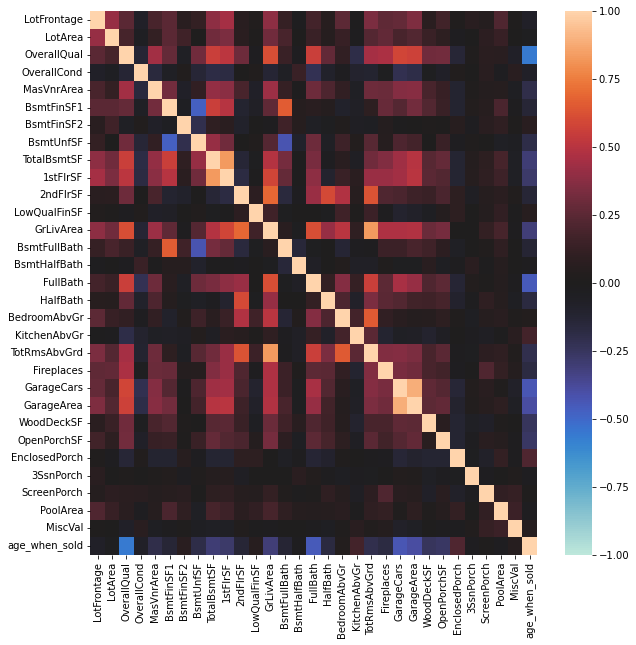

In [13]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(X_train.corr(), vmin = -1, center = 0, vmax = 1)

Como estaremos construindo modelos cujo protótipo é a regressão linear, vamos construir uma e medir o erro para termos um baseline de performance dos modelos seguintes.

In [14]:
lin_fit = LinearRegression()
lin_fit.fit(scaler.transform(X_train), y_train)

LinearRegression()

In [15]:
y_pred = lin_fit.predict(scaler.transform(X_test))

In [16]:
y_pred

array([252594.42987969, 120051.28483742, 222814.42404492, 112557.34615725,
       213090.44361509, 126180.77873661, 215904.44365639, 234567.95196745,
       301927.76417429,  84555.55942335, 191554.13266249, 197847.86496106,
       141530.53573806, 267424.65547038, 113929.50350161, 341688.35009204,
       139739.37334562, 282480.51580188,  96463.28262601, 217154.39113832,
       126907.6406803 , 140319.09234653, 325120.21836186, 199816.8444597 ,
       159324.23430434, 201758.62555577, 218979.31765672, 337624.60388983,
       284893.41331233, 137981.36692679, 259175.94200717, 159504.07875877,
       186695.61694814, 185425.7029762 , 109161.48822771, 122832.32799162,
       160893.11872182, 203358.93922149, 116075.88831112, 256859.00665585,
       156653.76617673, 191356.07730079, 206845.19190342, 233912.12012949,
        77684.14702015, 238963.38089805, 125875.60301121, 112889.74727585,
        59012.98693862, 271003.91634212, 179893.47176411, 127566.88926997,
       113963.94829686, 1

In [18]:
from sklearn.metrics import mean_squared_error
round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)

45432.89

In [19]:
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_pred), 2)}"
)


Erro de $45432.89 em $180538.11


## Extensões da Regressão

### Regressão Lasso

A regressão de Lasso trata a questão de colinearidade penalizando os coeficientes de variáveis correlatas entre si. O lasso aumenta a esparsidade dos coeficientes, reduzindo alguns coeficientes à zero e mantendo outros intactos.

**Quando utilizar:** quando temos uma estrutura de correlação entre as variáveis de entrada complexa e queremos um modelo interpretável sem sacrificar o poder preditivo do conjunto completo de variáveis.

**Análogo** uma regressão linear onde fizemos um feature selection que ao invés de excluir variáveis reduz a importância delas no modelo.

In [23]:
from sklearn.linear_model import LassoCV


A interface de utilização da regressão de lasso dentro da SKLEARN é igual aos outros modelos: inicializamos o objeto através da classe `LassoCV`, importada do sub-módulo `sklearn.linear_model`, e utilizamos o método fit para iniciar a aprendizagem do modelo.

O único hiperparâmetro de inicialização do modelo é a quantidade de dobras na validação cruzada: como o Lasso precisa estimar um parâmetro de regularização a função utiliza internamente uma validação cruzada para escolhe este parâmetro de forma ótima.

In [24]:
las_fit = LassoCV(cv=5)

las_fit.fit(scaler.transform(X_train), y_train)


LassoCV(cv=5)

In [25]:
y_pred = las_fit.predict(scaler.transform(X_test))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)


Erro de $43428.81 em $184151.13


O erro da regressão de lasso é maior! Será que isso indica um modelo pior? Vamos comparar os coeficientes estimados para cada variável para entender melhor o que está acontencedo. Primeiro vamos inicializar um dataframe com os coeficienetes da regressão lasso.

In [27]:
X_train.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'age_when_sold'],
      dtype='object')

In [33]:
coef_lin = pd.DataFrame(
    np.round(las_fit.coef_, 2), index=X_train.columns, columns=["lasso_fit"]
)


In [34]:
coef_lin

,lasso_fit
LotFrontage,0.00
LotArea,4854.41
OverallQual,27438.82
OverallCond,1279.24
MasVnrArea,8806.56
BsmtFinSF1,5240.68
BsmtFinSF2,0.00
BsmtUnfSF,-0.00
TotalBsmtSF,4457.33
1stFlrSF,2502.50


Agora vamos acrescentar os coeficientes da regressão linear.

In [35]:
coef_lin["lin_fit"] = lin_fit.coef_


O que podemos inferir da tabela abaixo?

In [36]:
coef_lin


,lasso_fit,lin_fit
LotFrontage,0.00,1.343029e+02
LotArea,4854.41,5.467686e+03
OverallQual,27438.82,2.587898e+04
OverallCond,1279.24,2.851633e+03
MasVnrArea,8806.56,9.436462e+03
BsmtFinSF1,5240.68,1.250637e+17
BsmtFinSF2,0.00,4.098744e+16
BsmtUnfSF,-0.00,1.173978e+17
TotalBsmtSF,4457.33,-1.214189e+17
1stFlrSF,2502.50,-4.888470e+16


Vamos analisar os 5 coeficientes que apresentaram a maior diferença relativa entre as duas regressões.

In [37]:
coef_lin["diff_lin_lasso"] = abs(coef_lin["lin_fit"] - coef_lin["lasso_fit"])/abs(coef_lin["lin_fit"])
coef_lin.sort_values("diff_lin_lasso", ascending=False).head()


,lasso_fit,lin_fit,diff_lin_lasso
1stFlrSF,2502.50,-4.888470e+16,1.0
TotalBsmtSF,4457.33,-1.214189e+17,1.0
BsmtUnfSF,-0.00,1.173978e+17,1.0
OpenPorchSF,-0.00,-8.282704e+02,1.0
EnclosedPorch,-0.00,2.934130e+02,1.0


In [39]:
coef_lin['abs_lasso'] = abs(coef_lin['lasso_fit'])
coef_lin.sort_values('abs_lasso', ascending = False)

,lasso_fit,lin_fit,diff_lin_lasso,abs_lasso
OverallQual,27438.82,2.587898e+04,0.060274,27438.82
GrLivArea,13943.36,6.711835e+16,1.000000,13943.36
GarageCars,9668.04,9.378744e+03,0.030846,9668.04
MasVnrArea,8806.56,9.436462e+03,0.066752,8806.56
PoolArea,-7392.44,-9.218817e+03,0.198114,7392.44
TotRmsAbvGrd,7346.84,1.163486e+04,0.368549,7346.84
age_when_sold,-6838.04,-6.332706e+03,0.079798,6838.04
BsmtFinSF1,5240.68,1.250637e+17,1.000000,5240.68
LotArea,4854.41,5.467686e+03,0.112164,4854.41
BsmtFullBath,4663.51,5.764858e+03,0.191045,4663.51


O caminho do lasso (`lasso path`) é a forma como o método foi 'encolhendo' cada coeficiente. A função `LassoCV` utiliza-se de validação cruzada para escolher um ponto neste caminho que minimize o erro de projeção. Podemos visualizar o caminho do lasso através do método `path`. Primeiro vamos inicializar um DataFrame com os dados do caminho de cada variável.

In [41]:
X_train.columns[0]

'LotFrontage'

In [40]:
las_fit.path(scaler.transform(X_train), y_train)[0]

array([66177.87280443, 61717.70566702, 57558.13886702, 53678.91294775,
       50061.13387212, 46687.18099791, 43540.6212552 , 40606.12910797,
       37869.41191007, 35317.14029183, 32936.8832385 , 30717.04754413,
       28646.82134602, 26716.12146487, 24915.54429387, 23236.31999788,
       21670.26979928, 20209.76614267, 18847.69554438, 17577.42394572,
       16392.76440137, 15287.94694538, 14257.59048824, 13296.67660782,
       12400.52510688, 11564.77121778, 10785.34434364, 10058.44823217,
        9380.54248577,  8748.32531781,  8158.71747102,  7608.84721974,
        7096.03638306,  6617.78728044,  6171.7705667 ,  5755.8138867 ,
        5367.89129477,  5006.11338721,  4668.71809979,  4354.06212552,
        4060.6129108 ,  3786.94119101,  3531.71402918,  3293.68832385,
        3071.70475441,  2864.6821346 ,  2671.61214649,  2491.55442939,
        2323.63199979,  2167.02697993,  2020.97661427,  1884.76955444,
        1757.74239457,  1639.27644014,  1528.79469454,  1425.75904882,
      

In [42]:
lasso_path = pd.DataFrame(
    las_fit.path(scaler.transform(X_train), y_train)[1].T, columns=X_train.columns
)
lasso_path["alpha"] = las_fit.path(scaler.transform(X_train), y_train)[0]
lasso_path.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,age_when_sold,alpha
0,0.0,0.0,1.558699e-11,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,66177.872804
1,0.0,0.0,4.460167e+03,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,61717.705667
2,0.0,0.0,8.619734e+03,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,57558.138867
3,0.0,0.0,1.249896e+04,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,53678.912948
4,0.0,0.0,1.611674e+04,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,50061.133872


In [47]:
lasso_path

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,age_when_sold,alpha
0,0.000000,0.000000,1.558699e-11,-0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,66177.872804
1,0.000000,0.000000,4.460167e+03,-0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,61717.705667
2,0.000000,0.000000,8.619734e+03,-0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,57558.138867
3,0.000000,0.000000,1.249896e+04,-0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,53678.912948
4,0.000000,0.000000,1.611674e+04,-0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,50061.133872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,5418.855553,2.593960e+04,2795.136705,9354.918552,4970.700714,737.494280,-0.0,5048.761163,3383.170453,...,2479.677424,2981.126973,-669.519999,173.375707,318.745082,3845.956649,-9086.603551,989.827079,-6310.018841,87.483253
96,4.349078,5421.328587,2.593260e+04,2803.433598,9358.920798,4971.876548,743.221557,-0.0,5052.521879,3389.923380,...,2481.073896,2983.241461,-680.119485,184.367996,323.080019,3851.666366,-9098.655355,997.414050,-6309.906930,81.587175
97,10.259255,5423.089878,2.592596e+04,2811.200900,9362.580690,4972.858575,748.560787,-0.0,5056.065949,3395.809370,...,2481.909881,2985.332566,-690.085070,194.544957,327.015806,3857.071227,-9110.097602,1004.462549,-6309.832305,76.088472
98,15.760288,5424.718237,2.591971e+04,2818.466351,9365.973508,4973.776579,753.535702,-0.0,5059.476598,3401.256016,...,2482.561382,2987.274552,-699.382517,204.036439,330.683220,3862.104173,-9120.770480,1011.041923,-6309.739399,70.960364


Agora vamos utilizar o método `melt` para transformar este DataFrame em formato longo.

In [48]:
lasso_path_long = lasso_path.melt(id_vars = ['alpha'])
lasso_path_long.tail(10)

,alpha,variable,value
3090,124.005251,age_when_sold,-6312.117121
3091,115.647712,age_when_sold,-6311.668498
3092,107.853443,age_when_sold,-6311.157037
3093,100.584482,age_when_sold,-6310.764926
3094,93.805425,age_when_sold,-6310.383325
3095,87.483253,age_when_sold,-6310.018841
3096,81.587175,age_when_sold,-6309.906930
3097,76.088472,age_when_sold,-6309.832305
3098,70.960364,age_when_sold,-6309.739399
3099,66.177873,age_when_sold,-6309.653174


In [50]:
lasso_path_long[lasso_path_long['variable'] == 'age_when_sold']

,alpha,variable,value
3000,66177.872804,age_when_sold,-0.000000
3001,61717.705667,age_when_sold,-0.000000
3002,57558.138867,age_when_sold,-0.000000
3003,53678.912948,age_when_sold,-0.000000
3004,50061.133872,age_when_sold,-0.000000
...,...,...,...
3095,87.483253,age_when_sold,-6310.018841
3096,81.587175,age_when_sold,-6309.906930
3097,76.088472,age_when_sold,-6309.832305
3098,70.960364,age_when_sold,-6309.739399


In [51]:
lasso_path_long['abs_value'] = abs(lasso_path_long['value'])

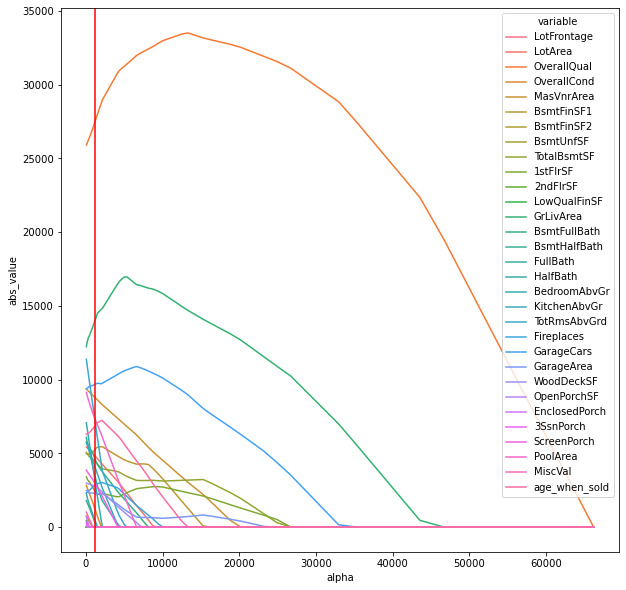

In [46]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(data=lasso_path_long, x="alpha", y="abs_value", hue = 'variable')
plt.axvline(las_fit.alpha_, color = 'red')

**Para se aprofundar**: Regressão LARS e Lasso-LARS

https://hastie.su.domains/ElemStatLearn/

### Regressão Ridge

Assim como a regressão de lasso, a regressão ridge busca resolver os problemas de colinearidade entre coeficientes e variáveis irrelevantes. No entanto, enquanto o lasso encolhe o coeficiente de algumas variáveis, a regressão ridge encolhe gradualmente todos os coeficientes. Ela é um método ideal para lidar com grandes conjuntos de variáveis, resolvendo automaticamente os problemas de colinearidade e overfitting que podem aconcetecer conforme aumentamos a complexidade de um modelo.

Uma utilização comum é na estimativa de funções não lineares a partir da adição de tranformações polinomiais das variáveis de entrada. Vamos continuar a análise do dataset de housing adicionando uma transformação não-linear bem útil: o beta-spline.

**Quando utilizar:** um método extremamente flexível, capaz de tratar grandes conjuntos de variáveis de forma simples. Sempre que quisermos utilizar transformações complexa para estimar formas funcionais desconhecidas. Muitas vezes apresenta performance superior à métodos bem ma
is complexos como boosting ou redes neurais.

**Problemas:** difícil interpretação do modelo, não captura relações entre variáveis como modelos de Boosting ou redes neurais.

**Análogo:** feature selection onde reduzimos a importancia do conjunto da variáveis para compensar o número de coeficientes sendo estimado.

In [52]:
from sklearn.linear_model import RidgeCV


Olhando apenas a descrição, a regressão de ridge parece identica ao Lasso. Essa impressão não esta completamente incorreta: ambas fazem parte da mesma classe de métodos: **métodos de regularização**. Para entender melhor a diferença de cada uma, vamos começar vendo uma transformação muito útil na construção de modelo preditivos lineares: os splines.

In [53]:
X_ex = pd.DataFrame({"x": np.linspace(0, 10, 100)})
X_ex


,x
0,0.00000
1,0.10101
2,0.20202
3,0.30303
4,0.40404
...,...
95,9.59596
96,9.69697
97,9.79798
98,9.89899


A transformação de spline é uma forma de representar relações não-lineares através de um modelo linear (como a transformação logaritmica). Podemos utilizar essa transformação através do objeto `SplineTransformer`, do sub-módulo `sklearn.preprocessing`.

In [54]:
from sklearn.preprocessing import SplineTransformer


Inicializamos o objeto como os outros transformadores da sklearn. O objeto tem diversos parâmetros que nos permitem controlar quantos splines iremos gerar e qual a complexidade deles. 

In [72]:
spl_trans = SplineTransformer(degree = 9)
spl_trans.fit(X_ex)

SplineTransformer(degree=9)

In [73]:
spl_trans.transform(X_ex).shape

(100, 13)

Vamos utilizar o método `transform` para construir um DataFrame com os resultados da transformação.

In [74]:
X_ex_spl = pd.DataFrame(
    spl_trans.transform(X_ex),
    columns=["S" + str(i) for i in range(spl_trans.n_features_out_)],
)
X_ex_spl["x"] = X_ex["x"]


In [75]:
X_ex_spl

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,x
0,2.755732e-06,0.001383,0.040256,2.431493e-01,0.430418,0.243149,0.040256,0.001383,0.000003,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000
1,1.901221e-06,0.001155,0.036353,2.318311e-01,0.430021,0.254517,0.044466,0.001650,0.000004,7.907881e-19,0.000000,0.000000,0.000000e+00,0.10101
2,1.290900e-06,0.000961,0.032747,2.206015e-01,0.428833,0.265894,0.048997,0.001960,0.000006,4.048835e-16,0.000000,0.000000,0.000000e+00,0.20202
3,8.613774e-07,0.000795,0.029423,2.094970e-01,0.426861,0.277238,0.053859,0.002319,0.000008,1.556508e-14,0.000000,0.000000,0.000000e+00,0.30303
4,5.639272e-07,0.000655,0.026368,1.985520e-01,0.424114,0.288504,0.059062,0.002733,0.000011,2.073004e-13,0.000000,0.000000,0.000000e+00,0.40404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000e+00,0.000000,0.000000,2.073004e-13,0.000011,0.002733,0.059062,0.288504,0.424114,1.985520e-01,0.026368,0.000655,5.639272e-07,9.59596
96,0.000000e+00,0.000000,0.000000,1.556508e-14,0.000008,0.002319,0.053859,0.277238,0.426861,2.094970e-01,0.029423,0.000795,8.613774e-07,9.69697
97,0.000000e+00,0.000000,0.000000,4.048835e-16,0.000006,0.001960,0.048997,0.265894,0.428833,2.206015e-01,0.032747,0.000961,1.290900e-06,9.79798
98,0.000000e+00,0.000000,0.000000,7.907881e-19,0.000004,0.001650,0.044466,0.254517,0.430021,2.318311e-01,0.036353,0.001155,1.901221e-06,9.89899


Agora vamos visualizar a transformação comparando cada spline gerada com o valor original.

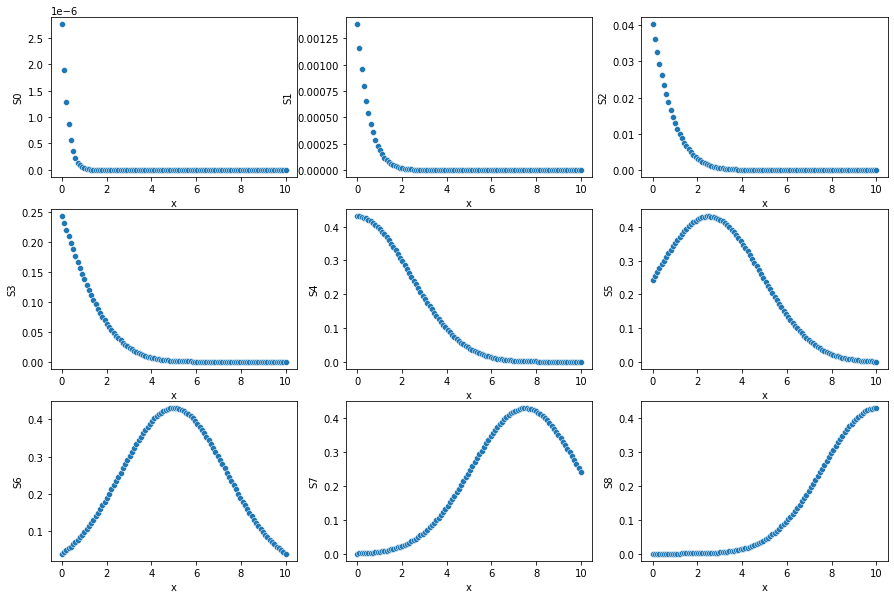

In [76]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
sp = 0
for i in range(3):
    for j in range(3):
        try:
            sns.scatterplot(data=X_ex_spl, x="x", y="S" + str(sp), ax=ax[i][j])
        except ValueError:
            continue
        sp += 1


Os splines funcionam como **um tipo de variável dummy continua**: ao invés de serem simplesmente binários, representam de maneira continua os pontos onde nossa variável X assume certos valores. Por exemplo, quando X = 10, os 4 primeiros splines (de 0 à 3) tem valor 0. Os 3 seguintes tem valores crescentes. **Quando inserimos isso em uma regressão estimamos efeitos locais**: o os splines 4, 5 e 6 conterão os efeitos da variável X sobre nossa variável resposta apenas quando X tem um valor alto!

Os métodos de ridge regression existem para tratar desse tipo de transformação: quando utilizamos um spline, como no exemplo acima, multiplicamos o número de variáveis que estamos inserindo em nosso modelo. Para controlar essa explosão de complexidade o ridge regression penaliza os coeficientes de forma conjunta, ao contrário do lasso, que penaliza cada coeficiente individualmente. Vamos ver isso na prática. Primeiro iremos treinar nossos splines.

In [62]:
spl_house = SplineTransformer(degree = 5)
spl_house.fit(scaler.transform(X_train))


SplineTransformer(degree=5)

In [65]:
X_train.shape

(956, 31)

In [64]:
spl_house.transform(scaler.transform(X_train)).shape

(956, 279)

Agora vamos utilizar o método `RidgeCV`, do sub-módulo `sklearn.linear_models`. Assim como no Lasso, o único parâmetro que devemos especificar é o `cv`. Utilizaremos nossas splines como features de entrada, passando o DataFrame `X_train` através do `scaler` e do `spl_house` antes de alimenta-lo ao `fit`.

In [66]:
rid_fit = RidgeCV(cv = 5)
rid_fit.fit(spl_house.transform(scaler.transform(X_train)), y_train)


RidgeCV(cv=5)

In [77]:
y_pred = rid_fit.predict(spl_house.transform(scaler.transform(X_test)))
print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $32604.44 em $184151.13


In [78]:
from sklearn.metrics import mean_squared_error
for i in range(1, 25):
    spl_house = SplineTransformer(degree = i)
    
    spl_house.fit(scaler.transform(X_train))
    
    rid_fit = RidgeCV(cv = 5)
    rid_fit.fit(spl_house.transform(scaler.transform(X_train)), y_train)
    
    y_pred = rid_fit.predict(spl_house.transform(scaler.transform(X_test)))
    print(
        f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
    )


Erro de $32554.93 em $184151.13
Erro de $33100.75 em $184151.13
Erro de $32032.68 em $184151.13
Erro de $32739.2 em $184151.13
Erro de $32604.44 em $184151.13
Erro de $32823.8 em $184151.13
Erro de $32873.36 em $184151.13
Erro de $32970.15 em $184151.13
Erro de $33047.07 em $184151.13
Erro de $33124.81 em $184151.13
Erro de $33201.55 em $184151.13
Erro de $33275.8 em $184151.13
Erro de $33348.72 em $184151.13
Erro de $33419.2 em $184151.13
Erro de $33487.74 em $184151.13
Erro de $33554.31 em $184151.13
Erro de $33567.77 em $184151.13
Erro de $33627.17 em $184151.13
Erro de $33681.99 em $184151.13
Erro de $33733.16 em $184151.13
Erro de $33781.32 em $184151.13
Erro de $33826.96 em $184151.13
Erro de $33870.38 em $184151.13
Erro de $33911.8 em $184151.13


Como podemos ver, mesmo adicionando inúmeros features não sofremos com overfitting. Essa é a principal qualidade do ridge regression, a capacidade de lidar com features criados através de transformações não lineares sem (muito) risco de overfitting.

Vamos comparar isto com uma regressão linear que utiliza os mesmos splines como features de entrada.

In [79]:
lin_spline_fit = LinearRegression()
lin_spline_fit.fit(spl_house.transform(scaler.transform(X_train)), y_train)
y_pred = lin_spline_fit.predict(spl_house.transform(scaler.transform(X_test)))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $70437663976481.72 em $184151.13


**Para se aprofundar** A regressão ElasticNet, que combina o Lasso com o Ridge.

## Métodos Não-Lineares
Embora os métodos lineares tenham vantagens claras (simplicidade, velocidade de implantação e interpretabilidade), em diversos problemas conseguimos uma performance preditiva melhor utilizando métodos não-lineares. Enquanto métodos lineares **sempre partem de uma função conhecida**, a da regressão linear, métodos não-lineares **não tem uma função conhecida prévia**: estimar esta função é *parte do trabalho do algoritmo*. Todos os classificadores que vimos dentro da SKLEARN até agora tem um regressor equivalente (árvores de decisão, kNN e métodos de ensemble) que podemos instanciar trocando o sufixo `Classifier` por `Regressor` (por exemplo, de `DecisionTreeClassifier` para `DecisionTreeRegressor`).

Sendo assim vamos comparar a performance do regressor de Floresta Aleatória, `RandomForestRegressor` (equivalente ao `RandomForestClassifier`) da sklearn com as regressões que fizemos até agora e aprender um método de outra biblioteca que representa o estado da arte em métodos de Machine Learning.

### Regressor de Floresta Aleatória

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [81]:
rfr_fit = RandomForestRegressor()
rfr_fit.fit(scaler.transform(X_train), y_train)

RandomForestRegressor()

In [82]:
y_pred = rfr_fit.predict(scaler.transform(X_test))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $30457.26 em $184151.13


In [91]:
max_depth_list = [1, 2, 4, 8, 16]
n_estimators_list = [50, 100, 300, 500, 1000]

param_grid = {
    'max_depth': max_depth_list,
    'n_estimators': n_estimators_list
}

param_grid

{'max_depth': [1, 2, 4, 8, 16], 'n_estimators': [50, 100, 300, 500, 1000]}

In [92]:
rfr_fit = RandomForestRegressor()

In [93]:
clf_fit = GridSearchCV(rfr_fit, param_grid, n_jobs = 6)

In [94]:
clf_fit.fit(scaler.transform(X_train), y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=6,
             param_grid={'max_depth': [1, 2, 4, 8, 16],
                         'n_estimators': [50, 100, 300, 500, 1000]})

In [95]:
print(clf_fit.best_estimator_)

RandomForestRegressor(max_depth=16)


In [96]:
y_pred = clf_fit.predict(scaler.transform(X_test))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $31820.28 em $184151.13


In [97]:
clf_fit.best_params_

{'max_depth': 16, 'n_estimators': 100}

### catboost

In [98]:
import catboost as cat

In [99]:
cat_fit = cat.CatBoostRegressor(verbose = False)
cat_fit.fit(scaler.transform(X_train), y_train)

In [102]:
cat_fit.tree_count_

1000

In [100]:
y_pred = cat_fit.predict(scaler.transform(X_test))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $31500.5 em $184151.13


In [105]:
cat_fit = cat.CatBoostRegressor(iterations = 20000, depth = 8, od_type = "Iter", od_wait = 500)
cat_fit.fit(scaler.transform(X_train), y_train, eval_set = (scaler.transform(X_test), y_test))

Learning rate set to 0.007067
0:	learn: 82377.2081716	test: 84283.3126859	best: 84283.3126859 (0)	total: 9.62ms	remaining: 3m 12s
1:	learn: 81998.3944034	test: 83928.6611365	best: 83928.6611365 (1)	total: 13.8ms	remaining: 2m 17s
2:	learn: 81601.3119391	test: 83550.5772319	best: 83550.5772319 (2)	total: 17ms	remaining: 1m 53s
3:	learn: 81261.2197345	test: 83289.8009906	best: 83289.8009906 (3)	total: 20.3ms	remaining: 1m 41s
4:	learn: 80891.4575928	test: 82975.2629161	best: 82975.2629161 (4)	total: 23.3ms	remaining: 1m 33s
5:	learn: 80526.4428817	test: 82623.1895690	best: 82623.1895690 (5)	total: 26.5ms	remaining: 1m 28s
6:	learn: 80154.7057725	test: 82295.9503421	best: 82295.9503421 (6)	total: 29.6ms	remaining: 1m 24s
7:	learn: 79812.1013803	test: 81962.6277720	best: 81962.6277720 (7)	total: 32.7ms	remaining: 1m 21s
8:	learn: 79498.5128706	test: 81671.3487479	best: 81671.3487479 (8)	total: 35.7ms	remaining: 1m 19s
9:	learn: 79112.6253744	test: 81342.2250914	best: 81342.2250914 (9)	tota

123:	learn: 50466.6547526	test: 56172.9547408	best: 56172.9547408 (123)	total: 382ms	remaining: 1m 1s
124:	learn: 50284.1307535	test: 56007.1091205	best: 56007.1091205 (124)	total: 385ms	remaining: 1m 1s
125:	learn: 50092.4750146	test: 55879.9340416	best: 55879.9340416 (125)	total: 387ms	remaining: 1m 1s
126:	learn: 49916.5190149	test: 55698.7828830	best: 55698.7828830 (126)	total: 391ms	remaining: 1m 1s
127:	learn: 49742.5047928	test: 55549.6698385	best: 55549.6698385 (127)	total: 394ms	remaining: 1m 1s
128:	learn: 49594.1682167	test: 55424.0294848	best: 55424.0294848 (128)	total: 397ms	remaining: 1m 1s
129:	learn: 49443.2443587	test: 55318.7892252	best: 55318.7892252 (129)	total: 400ms	remaining: 1m 1s
130:	learn: 49273.1794405	test: 55154.9683341	best: 55154.9683341 (130)	total: 403ms	remaining: 1m 1s
131:	learn: 49109.5064363	test: 55003.7987169	best: 55003.7987169 (131)	total: 406ms	remaining: 1m 1s
132:	learn: 48955.8654056	test: 54877.5822845	best: 54877.5822845 (132)	total: 409

252:	learn: 34735.3097543	test: 43679.8379887	best: 43679.8379887 (252)	total: 767ms	remaining: 59.9s
253:	learn: 34652.9149566	test: 43624.2351728	best: 43624.2351728 (253)	total: 770ms	remaining: 59.9s
254:	learn: 34576.2602465	test: 43587.3257549	best: 43587.3257549 (254)	total: 773ms	remaining: 59.9s
255:	learn: 34486.3539988	test: 43542.9960886	best: 43542.9960886 (255)	total: 776ms	remaining: 59.8s
256:	learn: 34397.1139815	test: 43507.0191784	best: 43507.0191784 (256)	total: 779ms	remaining: 59.8s
257:	learn: 34322.3880246	test: 43458.5549806	best: 43458.5549806 (257)	total: 782ms	remaining: 59.9s
258:	learn: 34250.8947069	test: 43415.1067373	best: 43415.1067373 (258)	total: 785ms	remaining: 59.9s
259:	learn: 34179.4972067	test: 43340.6374953	best: 43340.6374953 (259)	total: 788ms	remaining: 59.8s
260:	learn: 34088.5312624	test: 43299.2510977	best: 43299.2510977 (260)	total: 791ms	remaining: 59.8s
261:	learn: 34007.3266051	test: 43243.4756494	best: 43243.4756494 (261)	total: 794

367:	learn: 27618.2536446	test: 38822.1476812	best: 38822.1476812 (367)	total: 1.15s	remaining: 1m 1s
368:	learn: 27581.4510330	test: 38803.4200854	best: 38803.4200854 (368)	total: 1.15s	remaining: 1m 1s
369:	learn: 27533.5731705	test: 38789.8858907	best: 38789.8858907 (369)	total: 1.16s	remaining: 1m 1s
370:	learn: 27494.4200033	test: 38785.1137135	best: 38785.1137135 (370)	total: 1.16s	remaining: 1m 1s
371:	learn: 27445.7138834	test: 38744.0039737	best: 38744.0039737 (371)	total: 1.17s	remaining: 1m 1s
372:	learn: 27394.2098526	test: 38729.0878868	best: 38729.0878868 (372)	total: 1.17s	remaining: 1m 1s
373:	learn: 27343.2047761	test: 38718.6772346	best: 38718.6772346 (373)	total: 1.18s	remaining: 1m 1s
374:	learn: 27297.6009884	test: 38694.6056491	best: 38694.6056491 (374)	total: 1.18s	remaining: 1m 1s
375:	learn: 27255.3037781	test: 38687.8238289	best: 38687.8238289 (375)	total: 1.18s	remaining: 1m 1s
376:	learn: 27211.7419906	test: 38668.1389680	best: 38668.1389680 (376)	total: 1.1

478:	learn: 23610.3227138	test: 36527.9212234	best: 36527.9212234 (478)	total: 1.54s	remaining: 1m 2s
479:	learn: 23585.7901246	test: 36516.6223473	best: 36516.6223473 (479)	total: 1.54s	remaining: 1m 2s
480:	learn: 23555.8377859	test: 36504.0884338	best: 36504.0884338 (480)	total: 1.55s	remaining: 1m 2s
481:	learn: 23529.3523308	test: 36493.5811320	best: 36493.5811320 (481)	total: 1.55s	remaining: 1m 2s
482:	learn: 23501.8765518	test: 36476.4523625	best: 36476.4523625 (482)	total: 1.55s	remaining: 1m 2s
483:	learn: 23473.1131038	test: 36467.9891679	best: 36467.9891679 (483)	total: 1.56s	remaining: 1m 2s
484:	learn: 23442.5140812	test: 36448.1758608	best: 36448.1758608 (484)	total: 1.56s	remaining: 1m 2s
485:	learn: 23418.7756573	test: 36449.2182337	best: 36448.1758608 (484)	total: 1.57s	remaining: 1m 2s
486:	learn: 23390.6854733	test: 36421.1294047	best: 36421.1294047 (486)	total: 1.57s	remaining: 1m 2s
487:	learn: 23361.9543540	test: 36411.8385757	best: 36411.8385757 (487)	total: 1.5

583:	learn: 21225.5155238	test: 35262.0281573	best: 35262.0281573 (583)	total: 1.93s	remaining: 1m 4s
584:	learn: 21203.7134035	test: 35253.2096950	best: 35253.2096950 (584)	total: 1.93s	remaining: 1m 4s
585:	learn: 21184.3414914	test: 35241.1004162	best: 35241.1004162 (585)	total: 1.93s	remaining: 1m 4s
586:	learn: 21162.7169367	test: 35230.4491482	best: 35230.4491482 (586)	total: 1.94s	remaining: 1m 4s
587:	learn: 21147.1971965	test: 35229.7613573	best: 35229.7613573 (587)	total: 1.94s	remaining: 1m 4s
588:	learn: 21133.7686831	test: 35225.9724446	best: 35225.9724446 (588)	total: 1.94s	remaining: 1m 4s
589:	learn: 21117.3852439	test: 35220.6020405	best: 35220.6020405 (589)	total: 1.95s	remaining: 1m 4s
590:	learn: 21098.9458606	test: 35209.3016999	best: 35209.3016999 (590)	total: 1.95s	remaining: 1m 4s
591:	learn: 21083.9199748	test: 35199.5920963	best: 35199.5920963 (591)	total: 1.95s	remaining: 1m 4s
592:	learn: 21071.0382470	test: 35198.3262113	best: 35198.3262113 (592)	total: 1.9

711:	learn: 19327.6940794	test: 34279.8455843	best: 34279.8455843 (711)	total: 2.31s	remaining: 1m 2s
712:	learn: 19317.8688643	test: 34272.0426103	best: 34272.0426103 (712)	total: 2.31s	remaining: 1m 2s
713:	learn: 19301.3471497	test: 34250.8178906	best: 34250.8178906 (713)	total: 2.32s	remaining: 1m 2s
714:	learn: 19290.1263751	test: 34246.4242768	best: 34246.4242768 (714)	total: 2.32s	remaining: 1m 2s
715:	learn: 19279.3945666	test: 34233.2780000	best: 34233.2780000 (715)	total: 2.32s	remaining: 1m 2s
716:	learn: 19266.3617572	test: 34228.8754882	best: 34228.8754882 (716)	total: 2.33s	remaining: 1m 2s
717:	learn: 19255.5324710	test: 34215.6766956	best: 34215.6766956 (717)	total: 2.33s	remaining: 1m 2s
718:	learn: 19247.2896344	test: 34207.1688153	best: 34207.1688153 (718)	total: 2.33s	remaining: 1m 2s
719:	learn: 19231.3610771	test: 34199.3409675	best: 34199.3409675 (719)	total: 2.33s	remaining: 1m 2s
720:	learn: 19217.0916700	test: 34196.4461573	best: 34196.4461573 (720)	total: 2.3

846:	learn: 17952.2460406	test: 33492.4986469	best: 33492.4986469 (846)	total: 2.7s	remaining: 1m 1s
847:	learn: 17945.1651251	test: 33480.9303357	best: 33480.9303357 (847)	total: 2.7s	remaining: 1m 1s
848:	learn: 17937.3110654	test: 33480.4738058	best: 33480.4738058 (848)	total: 2.71s	remaining: 1m 1s
849:	learn: 17932.2745803	test: 33472.9521843	best: 33472.9521843 (849)	total: 2.71s	remaining: 1m 1s
850:	learn: 17927.9784224	test: 33463.2466537	best: 33463.2466537 (850)	total: 2.71s	remaining: 1m 1s
851:	learn: 17918.1262745	test: 33462.1917633	best: 33462.1917633 (851)	total: 2.72s	remaining: 1m 1s
852:	learn: 17913.1327728	test: 33452.6122150	best: 33452.6122150 (852)	total: 2.72s	remaining: 1m 1s
853:	learn: 17905.3175448	test: 33453.0814413	best: 33452.6122150 (852)	total: 2.72s	remaining: 1m 1s
854:	learn: 17899.5617420	test: 33452.1123226	best: 33452.1123226 (854)	total: 2.73s	remaining: 1m 1s
855:	learn: 17894.2710590	test: 33444.3154133	best: 33444.3154133 (855)	total: 2.73s

971:	learn: 17094.0095462	test: 33016.4011880	best: 33016.4011880 (971)	total: 3.07s	remaining: 1m
972:	learn: 17091.3901702	test: 33015.7673058	best: 33015.7673058 (972)	total: 3.08s	remaining: 1m
973:	learn: 17086.1201407	test: 33013.8779073	best: 33013.8779073 (973)	total: 3.08s	remaining: 1m
974:	learn: 17081.1455187	test: 33013.9739972	best: 33013.8779073 (973)	total: 3.08s	remaining: 1m
975:	learn: 17076.7522549	test: 33014.1464395	best: 33013.8779073 (973)	total: 3.08s	remaining: 1m
976:	learn: 17068.3834339	test: 33017.6705997	best: 33013.8779073 (973)	total: 3.09s	remaining: 1m
977:	learn: 17058.3818689	test: 33013.0366908	best: 33013.0366908 (977)	total: 3.09s	remaining: 1m
978:	learn: 17054.8450371	test: 33012.4407332	best: 33012.4407332 (978)	total: 3.09s	remaining: 1m
979:	learn: 17045.8169711	test: 33009.4196641	best: 33009.4196641 (979)	total: 3.1s	remaining: 1m
980:	learn: 17040.0384402	test: 33008.0421031	best: 33008.0421031 (980)	total: 3.1s	remaining: 1m
981:	learn: 

1090:	learn: 16329.9214477	test: 32655.9293218	best: 32655.9293218 (1090)	total: 3.41s	remaining: 59.1s
1091:	learn: 16318.1277678	test: 32655.7708530	best: 32655.7708530 (1091)	total: 3.41s	remaining: 59.1s
1092:	learn: 16311.9774382	test: 32650.1970146	best: 32650.1970146 (1092)	total: 3.41s	remaining: 59.1s
1093:	learn: 16309.6086729	test: 32644.5067608	best: 32644.5067608 (1093)	total: 3.42s	remaining: 59.1s
1094:	learn: 16303.7989519	test: 32637.3383018	best: 32637.3383018 (1094)	total: 3.42s	remaining: 59.1s
1095:	learn: 16296.3577544	test: 32630.7796245	best: 32630.7796245 (1095)	total: 3.42s	remaining: 59s
1096:	learn: 16292.9231283	test: 32624.5244991	best: 32624.5244991 (1096)	total: 3.43s	remaining: 59s
1097:	learn: 16286.3822119	test: 32617.9537957	best: 32617.9537957 (1097)	total: 3.43s	remaining: 59s
1098:	learn: 16281.6074691	test: 32617.7981734	best: 32617.7981734 (1098)	total: 3.43s	remaining: 59s
1099:	learn: 16278.3606523	test: 32614.8855640	best: 32614.8855640 (1099

1217:	learn: 15595.2673766	test: 32285.5460790	best: 32284.2290875 (1215)	total: 3.8s	remaining: 58.6s
1218:	learn: 15586.3648008	test: 32283.0642710	best: 32283.0642710 (1218)	total: 3.8s	remaining: 58.5s
1219:	learn: 15581.2182877	test: 32282.5988347	best: 32282.5988347 (1219)	total: 3.8s	remaining: 58.5s
1220:	learn: 15577.6760138	test: 32277.5189155	best: 32277.5189155 (1220)	total: 3.8s	remaining: 58.5s
1221:	learn: 15574.7544848	test: 32273.2634265	best: 32273.2634265 (1221)	total: 3.81s	remaining: 58.5s
1222:	learn: 15564.9705892	test: 32268.6894846	best: 32268.6894846 (1222)	total: 3.81s	remaining: 58.5s
1223:	learn: 15556.2357736	test: 32264.0549877	best: 32264.0549877 (1223)	total: 3.81s	remaining: 58.5s
1224:	learn: 15544.9553724	test: 32259.3263790	best: 32259.3263790 (1224)	total: 3.82s	remaining: 58.5s
1225:	learn: 15539.3186253	test: 32255.5523616	best: 32255.5523616 (1225)	total: 3.82s	remaining: 58.5s
1226:	learn: 15534.3374180	test: 32255.9837959	best: 32255.5523616 (

1345:	learn: 14854.1733608	test: 31958.5171836	best: 31958.5171836 (1345)	total: 4.18s	remaining: 58s
1346:	learn: 14842.4390820	test: 31961.0217634	best: 31958.5171836 (1345)	total: 4.19s	remaining: 58s
1347:	learn: 14833.4754623	test: 31957.8392225	best: 31957.8392225 (1347)	total: 4.19s	remaining: 58s
1348:	learn: 14831.4412869	test: 31954.8125822	best: 31954.8125822 (1348)	total: 4.2s	remaining: 58s
1349:	learn: 14823.8070104	test: 31954.8315024	best: 31954.8125822 (1348)	total: 4.2s	remaining: 58s
1350:	learn: 14821.3257037	test: 31955.8224561	best: 31954.8125822 (1348)	total: 4.2s	remaining: 58s
1351:	learn: 14817.7791015	test: 31950.0923848	best: 31950.0923848 (1351)	total: 4.21s	remaining: 58s
1352:	learn: 14812.6765348	test: 31947.2469123	best: 31947.2469123 (1352)	total: 4.21s	remaining: 58.1s
1353:	learn: 14806.9951309	test: 31944.8527681	best: 31944.8527681 (1353)	total: 4.22s	remaining: 58.1s
1354:	learn: 14803.1630926	test: 31942.4234144	best: 31942.4234144 (1354)	total: 

1466:	learn: 14174.2654859	test: 31816.7643451	best: 31816.1818947 (1464)	total: 4.57s	remaining: 57.8s
1467:	learn: 14171.2206228	test: 31816.1740647	best: 31816.1740647 (1467)	total: 4.58s	remaining: 57.8s
1468:	learn: 14161.4847977	test: 31814.9696833	best: 31814.9696833 (1468)	total: 4.58s	remaining: 57.8s
1469:	learn: 14151.9146340	test: 31814.5843926	best: 31814.5843926 (1469)	total: 4.58s	remaining: 57.8s
1470:	learn: 14149.2226699	test: 31809.6545468	best: 31809.6545468 (1470)	total: 4.58s	remaining: 57.8s
1471:	learn: 14145.7513597	test: 31807.3284102	best: 31807.3284102 (1471)	total: 4.59s	remaining: 57.8s
1472:	learn: 14141.0653107	test: 31807.6177321	best: 31807.3284102 (1471)	total: 4.59s	remaining: 57.7s
1473:	learn: 14140.1139753	test: 31807.8545179	best: 31807.3284102 (1471)	total: 4.59s	remaining: 57.8s
1474:	learn: 14132.8870240	test: 31806.9381604	best: 31806.9381604 (1474)	total: 4.6s	remaining: 57.8s
1475:	learn: 14127.6328174	test: 31804.5414448	best: 31804.541444

1593:	learn: 13480.7248394	test: 31640.3859241	best: 31640.3859241 (1593)	total: 4.96s	remaining: 57.3s
1594:	learn: 13475.5355622	test: 31637.8628677	best: 31637.8628677 (1594)	total: 4.96s	remaining: 57.3s
1595:	learn: 13474.4383722	test: 31635.4545582	best: 31635.4545582 (1595)	total: 4.97s	remaining: 57.3s
1596:	learn: 13462.8244662	test: 31634.0252878	best: 31634.0252878 (1596)	total: 4.97s	remaining: 57.3s
1597:	learn: 13456.0870058	test: 31633.9954224	best: 31633.9954224 (1597)	total: 4.97s	remaining: 57.3s
1598:	learn: 13449.0662786	test: 31633.2096913	best: 31633.2096913 (1598)	total: 4.98s	remaining: 57.3s
1599:	learn: 13448.2858670	test: 31633.4601020	best: 31633.2096913 (1598)	total: 4.98s	remaining: 57.3s
1600:	learn: 13446.4221833	test: 31634.3774712	best: 31633.2096913 (1598)	total: 4.98s	remaining: 57.3s
1601:	learn: 13443.5005870	test: 31633.2069841	best: 31633.2069841 (1601)	total: 4.99s	remaining: 57.3s
1602:	learn: 13439.9588361	test: 31634.4384819	best: 31633.20698

1722:	learn: 12816.6572492	test: 31519.9229823	best: 31519.9229823 (1722)	total: 5.34s	remaining: 56.7s
1723:	learn: 12810.2770777	test: 31520.3584033	best: 31519.9229823 (1722)	total: 5.35s	remaining: 56.7s
1724:	learn: 12806.7914392	test: 31518.3379263	best: 31518.3379263 (1724)	total: 5.35s	remaining: 56.7s
1725:	learn: 12798.1032037	test: 31518.2928911	best: 31518.2928911 (1725)	total: 5.36s	remaining: 56.7s
1726:	learn: 12793.7843136	test: 31518.7024843	best: 31518.2928911 (1725)	total: 5.36s	remaining: 56.7s
1727:	learn: 12793.2944315	test: 31520.3500497	best: 31518.2928911 (1725)	total: 5.36s	remaining: 56.7s
1728:	learn: 12787.7066231	test: 31521.5245482	best: 31518.2928911 (1725)	total: 5.36s	remaining: 56.7s
1729:	learn: 12783.1081949	test: 31521.8059835	best: 31518.2928911 (1725)	total: 5.37s	remaining: 56.7s
1730:	learn: 12782.6122809	test: 31520.7170558	best: 31518.2928911 (1725)	total: 5.37s	remaining: 56.7s
1731:	learn: 12775.3827381	test: 31519.7530541	best: 31518.29289

1853:	learn: 12168.5141746	test: 31430.5843555	best: 31430.5843555 (1853)	total: 5.74s	remaining: 56.2s
1854:	learn: 12164.3887913	test: 31430.7712680	best: 31430.5843555 (1853)	total: 5.74s	remaining: 56.2s
1855:	learn: 12157.0565894	test: 31428.9079339	best: 31428.9079339 (1855)	total: 5.75s	remaining: 56.2s
1856:	learn: 12154.6758149	test: 31428.6698256	best: 31428.6698256 (1856)	total: 5.75s	remaining: 56.2s
1857:	learn: 12150.4498622	test: 31430.7335248	best: 31428.6698256 (1856)	total: 5.75s	remaining: 56.2s
1858:	learn: 12146.8137896	test: 31430.1991841	best: 31428.6698256 (1856)	total: 5.76s	remaining: 56.2s
1859:	learn: 12141.5033088	test: 31431.7652203	best: 31428.6698256 (1856)	total: 5.76s	remaining: 56.2s
1860:	learn: 12137.3073026	test: 31431.8135735	best: 31428.6698256 (1856)	total: 5.76s	remaining: 56.2s
1861:	learn: 12135.2482160	test: 31431.6107232	best: 31428.6698256 (1856)	total: 5.77s	remaining: 56.2s
1862:	learn: 12132.9667816	test: 31430.5524927	best: 31428.66982

1985:	learn: 11629.8219884	test: 31345.7282085	best: 31345.7282085 (1985)	total: 6.13s	remaining: 55.6s
1986:	learn: 11626.5569037	test: 31346.4205087	best: 31345.7282085 (1985)	total: 6.13s	remaining: 55.6s
1987:	learn: 11624.1148836	test: 31344.8140079	best: 31344.8140079 (1987)	total: 6.13s	remaining: 55.6s
1988:	learn: 11620.1748140	test: 31343.9604334	best: 31343.9604334 (1988)	total: 6.14s	remaining: 55.6s
1989:	learn: 11616.3789292	test: 31341.2111708	best: 31341.2111708 (1989)	total: 6.14s	remaining: 55.6s
1990:	learn: 11616.0609017	test: 31340.5359929	best: 31340.5359929 (1990)	total: 6.14s	remaining: 55.6s
1991:	learn: 11607.6770159	test: 31337.3354870	best: 31337.3354870 (1991)	total: 6.14s	remaining: 55.6s
1992:	learn: 11603.2752437	test: 31338.6215617	best: 31337.3354870 (1991)	total: 6.15s	remaining: 55.6s
1993:	learn: 11597.3822483	test: 31338.0997977	best: 31337.3354870 (1991)	total: 6.15s	remaining: 55.6s
1994:	learn: 11593.8862982	test: 31339.8544738	best: 31337.33548

2122:	learn: 11094.3833560	test: 31261.8159215	best: 31261.8159215 (2122)	total: 6.52s	remaining: 54.9s
2123:	learn: 11089.7729620	test: 31258.7805876	best: 31258.7805876 (2123)	total: 6.52s	remaining: 54.9s
2124:	learn: 11085.4775436	test: 31257.6989146	best: 31257.6989146 (2124)	total: 6.52s	remaining: 54.9s
2125:	learn: 11081.4418944	test: 31257.0631921	best: 31257.0631921 (2125)	total: 6.53s	remaining: 54.9s
2126:	learn: 11078.6128431	test: 31255.5868046	best: 31255.5868046 (2126)	total: 6.53s	remaining: 54.9s
2127:	learn: 11073.8720014	test: 31255.2343624	best: 31255.2343624 (2127)	total: 6.53s	remaining: 54.9s
2128:	learn: 11068.5227455	test: 31254.4259829	best: 31254.4259829 (2128)	total: 6.54s	remaining: 54.9s
2129:	learn: 11066.3498638	test: 31253.2580454	best: 31253.2580454 (2129)	total: 6.54s	remaining: 54.9s
2130:	learn: 11064.8448997	test: 31253.4806976	best: 31253.2580454 (2129)	total: 6.54s	remaining: 54.9s
2131:	learn: 11059.5791774	test: 31252.4438010	best: 31252.44380

2260:	learn: 10618.5778925	test: 31196.3662670	best: 31196.3068913 (2257)	total: 6.91s	remaining: 54.2s
2261:	learn: 10610.4613325	test: 31193.6810796	best: 31193.6810796 (2261)	total: 6.91s	remaining: 54.2s
2262:	learn: 10606.3275204	test: 31193.2130831	best: 31193.2130831 (2262)	total: 6.91s	remaining: 54.2s
2263:	learn: 10601.1000544	test: 31193.1626970	best: 31193.1626970 (2263)	total: 6.92s	remaining: 54.2s
2264:	learn: 10599.2790305	test: 31192.9164835	best: 31192.9164835 (2264)	total: 6.92s	remaining: 54.2s
2265:	learn: 10593.1745299	test: 31193.0002473	best: 31192.9164835 (2264)	total: 6.92s	remaining: 54.2s
2266:	learn: 10592.7737011	test: 31191.8738943	best: 31191.8738943 (2266)	total: 6.92s	remaining: 54.2s
2267:	learn: 10589.0195435	test: 31193.8675718	best: 31191.8738943 (2266)	total: 6.93s	remaining: 54.2s
2268:	learn: 10585.9747330	test: 31194.3135603	best: 31191.8738943 (2266)	total: 6.93s	remaining: 54.2s
2269:	learn: 10585.5712489	test: 31194.5762963	best: 31191.87389

2396:	learn: 10168.4326421	test: 31149.8962114	best: 31149.8502477 (2395)	total: 7.29s	remaining: 53.6s
2397:	learn: 10161.8233471	test: 31147.2893919	best: 31147.2893919 (2397)	total: 7.3s	remaining: 53.6s
2398:	learn: 10157.8602694	test: 31146.7078209	best: 31146.7078209 (2398)	total: 7.3s	remaining: 53.6s
2399:	learn: 10154.6168911	test: 31146.4490138	best: 31146.4490138 (2399)	total: 7.3s	remaining: 53.6s
2400:	learn: 10150.2633817	test: 31147.4290843	best: 31146.4490138 (2399)	total: 7.31s	remaining: 53.6s
2401:	learn: 10147.2068382	test: 31146.4363670	best: 31146.4363670 (2401)	total: 7.31s	remaining: 53.6s
2402:	learn: 10144.6065536	test: 31147.2600846	best: 31146.4363670 (2401)	total: 7.31s	remaining: 53.6s
2403:	learn: 10139.4451008	test: 31145.3287866	best: 31145.3287866 (2403)	total: 7.32s	remaining: 53.6s
2404:	learn: 10135.2189730	test: 31143.8918112	best: 31143.8918112 (2404)	total: 7.32s	remaining: 53.6s
2405:	learn: 10130.6314140	test: 31144.4954722	best: 31143.8918112 

2536:	learn: 9712.4057040	test: 31106.5510335	best: 31106.5510335 (2536)	total: 7.68s	remaining: 52.9s
2537:	learn: 9710.1260723	test: 31106.3751338	best: 31106.3751338 (2537)	total: 7.69s	remaining: 52.9s
2538:	learn: 9705.0494996	test: 31105.5560199	best: 31105.5560199 (2538)	total: 7.69s	remaining: 52.9s
2539:	learn: 9699.6392191	test: 31104.6119050	best: 31104.6119050 (2539)	total: 7.69s	remaining: 52.9s
2540:	learn: 9694.6462858	test: 31104.8439042	best: 31104.6119050 (2539)	total: 7.69s	remaining: 52.9s
2541:	learn: 9691.7494580	test: 31105.7465241	best: 31104.6119050 (2539)	total: 7.7s	remaining: 52.9s
2542:	learn: 9691.4679215	test: 31104.7951551	best: 31104.6119050 (2539)	total: 7.7s	remaining: 52.9s
2543:	learn: 9687.7402389	test: 31104.2026438	best: 31104.2026438 (2543)	total: 7.7s	remaining: 52.9s
2544:	learn: 9687.2244817	test: 31103.5431867	best: 31103.5431867 (2544)	total: 7.71s	remaining: 52.9s
2545:	learn: 9684.9047369	test: 31104.0295054	best: 31103.5431867 (2544)	tot

2673:	learn: 9295.9500333	test: 31078.0176850	best: 31077.3553902 (2669)	total: 8.07s	remaining: 52.3s
2674:	learn: 9293.5713937	test: 31079.5181989	best: 31077.3553902 (2669)	total: 8.07s	remaining: 52.3s
2675:	learn: 9292.2924176	test: 31079.1764866	best: 31077.3553902 (2669)	total: 8.08s	remaining: 52.3s
2676:	learn: 9290.4710097	test: 31078.2168059	best: 31077.3553902 (2669)	total: 8.08s	remaining: 52.3s
2677:	learn: 9288.3639135	test: 31077.3568133	best: 31077.3553902 (2669)	total: 8.08s	remaining: 52.3s
2678:	learn: 9285.7286399	test: 31077.9932170	best: 31077.3553902 (2669)	total: 8.08s	remaining: 52.3s
2679:	learn: 9283.8497737	test: 31077.5508539	best: 31077.3553902 (2669)	total: 8.09s	remaining: 52.3s
2680:	learn: 9281.2879178	test: 31078.1693320	best: 31077.3553902 (2669)	total: 8.09s	remaining: 52.3s
2681:	learn: 9277.6507555	test: 31077.9794432	best: 31077.3553902 (2669)	total: 8.09s	remaining: 52.3s
2682:	learn: 9273.4160060	test: 31076.6181814	best: 31076.6181814 (2682)	

2812:	learn: 8879.3936647	test: 31063.1166502	best: 31060.2952574 (2746)	total: 8.46s	remaining: 51.7s
2813:	learn: 8878.4933795	test: 31061.8291474	best: 31060.2952574 (2746)	total: 8.46s	remaining: 51.7s
2814:	learn: 8874.5252287	test: 31060.2904940	best: 31060.2904940 (2814)	total: 8.47s	remaining: 51.7s
2815:	learn: 8872.0868468	test: 31060.0330929	best: 31060.0330929 (2815)	total: 8.47s	remaining: 51.7s
2816:	learn: 8871.7415601	test: 31058.8175083	best: 31058.8175083 (2816)	total: 8.47s	remaining: 51.7s
2817:	learn: 8868.6019144	test: 31058.5319063	best: 31058.5319063 (2817)	total: 8.48s	remaining: 51.7s
2818:	learn: 8864.3316005	test: 31058.5978247	best: 31058.5319063 (2817)	total: 8.48s	remaining: 51.7s
2819:	learn: 8862.3464280	test: 31058.5530900	best: 31058.5319063 (2817)	total: 8.48s	remaining: 51.7s
2820:	learn: 8858.7067144	test: 31058.9777427	best: 31058.5319063 (2817)	total: 8.49s	remaining: 51.7s
2821:	learn: 8858.4997563	test: 31059.0415618	best: 31058.5319063 (2817)	

2949:	learn: 8480.8919031	test: 31015.5046364	best: 31015.5046364 (2949)	total: 8.85s	remaining: 51.1s
2950:	learn: 8479.5600921	test: 31015.4586241	best: 31015.4586241 (2950)	total: 8.85s	remaining: 51.1s
2951:	learn: 8477.0553375	test: 31014.5899599	best: 31014.5899599 (2951)	total: 8.85s	remaining: 51.1s
2952:	learn: 8475.6888340	test: 31015.8654213	best: 31014.5899599 (2951)	total: 8.86s	remaining: 51.1s
2953:	learn: 8475.4963214	test: 31015.5032526	best: 31014.5899599 (2951)	total: 8.86s	remaining: 51.1s
2954:	learn: 8472.3458484	test: 31013.8056100	best: 31013.8056100 (2954)	total: 8.86s	remaining: 51.1s
2955:	learn: 8470.0631488	test: 31011.8526517	best: 31011.8526517 (2955)	total: 8.87s	remaining: 51.1s
2956:	learn: 8466.5968689	test: 31012.2532602	best: 31011.8526517 (2955)	total: 8.87s	remaining: 51.1s
2957:	learn: 8464.0710238	test: 31011.2356025	best: 31011.2356025 (2957)	total: 8.87s	remaining: 51.1s
2958:	learn: 8461.1613502	test: 31011.5094829	best: 31011.2356025 (2957)	

3088:	learn: 8141.6247490	test: 31004.0001534	best: 31003.7556874 (3087)	total: 9.24s	remaining: 50.6s
3089:	learn: 8137.6021852	test: 31004.0073343	best: 31003.7556874 (3087)	total: 9.24s	remaining: 50.6s
3090:	learn: 8135.4317469	test: 31005.2636616	best: 31003.7556874 (3087)	total: 9.24s	remaining: 50.6s
3091:	learn: 8131.5110968	test: 31005.3059791	best: 31003.7556874 (3087)	total: 9.24s	remaining: 50.6s
3092:	learn: 8131.3744017	test: 31004.8796454	best: 31003.7556874 (3087)	total: 9.25s	remaining: 50.5s
3093:	learn: 8127.1352108	test: 31005.1485839	best: 31003.7556874 (3087)	total: 9.25s	remaining: 50.5s
3094:	learn: 8122.8808630	test: 31004.0115101	best: 31003.7556874 (3087)	total: 9.25s	remaining: 50.5s
3095:	learn: 8116.9897099	test: 31004.1894961	best: 31003.7556874 (3087)	total: 9.26s	remaining: 50.5s
3096:	learn: 8114.5019424	test: 31003.9798954	best: 31003.7556874 (3087)	total: 9.26s	remaining: 50.5s
3097:	learn: 8114.3238990	test: 31003.2774068	best: 31003.2774068 (3097)	

3222:	learn: 7783.4744965	test: 30988.0072029	best: 30986.8910736 (3219)	total: 9.63s	remaining: 50.1s
3223:	learn: 7780.3202165	test: 30987.1602541	best: 30986.8910736 (3219)	total: 9.63s	remaining: 50.1s
3224:	learn: 7779.3917666	test: 30988.7652068	best: 30986.8910736 (3219)	total: 9.63s	remaining: 50.1s
3225:	learn: 7774.9397149	test: 30988.2919641	best: 30986.8910736 (3219)	total: 9.63s	remaining: 50.1s
3226:	learn: 7771.3970106	test: 30988.4212065	best: 30986.8910736 (3219)	total: 9.64s	remaining: 50.1s
3227:	learn: 7769.1957679	test: 30988.5835180	best: 30986.8910736 (3219)	total: 9.64s	remaining: 50.1s
3228:	learn: 7766.4017386	test: 30988.3762242	best: 30986.8910736 (3219)	total: 9.64s	remaining: 50.1s
3229:	learn: 7763.7363045	test: 30988.3798424	best: 30986.8910736 (3219)	total: 9.65s	remaining: 50.1s
3230:	learn: 7760.6723432	test: 30988.3990083	best: 30986.8910736 (3219)	total: 9.65s	remaining: 50.1s
3231:	learn: 7758.0789450	test: 30986.9488214	best: 30986.8910736 (3219)	

3356:	learn: 7425.2111538	test: 30972.0885159	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3357:	learn: 7423.2879189	test: 30971.3878058	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3358:	learn: 7420.9829797	test: 30972.3327099	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3359:	learn: 7420.8133027	test: 30972.3574208	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3360:	learn: 7418.3627900	test: 30972.6589591	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3361:	learn: 7417.3542431	test: 30974.5340434	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3362:	learn: 7415.0949358	test: 30976.0992851	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3363:	learn: 7413.7888115	test: 30976.4076278	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3364:	learn: 7411.5444099	test: 30976.0401219	best: 30968.5004033 (3352)	total: 10s	remaining: 49.6s
3365:	learn: 7408.5544938	test: 30976.5592709	best: 30968.5004033 (3352)	total: 10s	remaini

3494:	learn: 7084.5547022	test: 30967.5855038	best: 30966.5836969 (3492)	total: 10.4s	remaining: 49.1s
3495:	learn: 7082.8300335	test: 30967.7161385	best: 30966.5836969 (3492)	total: 10.4s	remaining: 49.1s
3496:	learn: 7079.8642550	test: 30967.8948751	best: 30966.5836969 (3492)	total: 10.4s	remaining: 49.1s
3497:	learn: 7077.3484947	test: 30968.6036390	best: 30966.5836969 (3492)	total: 10.4s	remaining: 49.1s
3498:	learn: 7075.5070542	test: 30968.1261014	best: 30966.5836969 (3492)	total: 10.4s	remaining: 49.1s
3499:	learn: 7071.9062662	test: 30968.1086134	best: 30966.5836969 (3492)	total: 10.4s	remaining: 49.1s
3500:	learn: 7069.7981723	test: 30967.8392999	best: 30966.5836969 (3492)	total: 10.4s	remaining: 49.1s
3501:	learn: 7066.9835657	test: 30965.5039263	best: 30965.5039263 (3501)	total: 10.4s	remaining: 49.1s
3502:	learn: 7064.6444739	test: 30965.2311286	best: 30965.2311286 (3502)	total: 10.4s	remaining: 49.1s
3503:	learn: 7061.2567252	test: 30963.8506448	best: 30963.8506448 (3503)	

3629:	learn: 6755.9182211	test: 30953.9139497	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3630:	learn: 6753.4984513	test: 30954.3062251	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3631:	learn: 6752.0908254	test: 30953.9341130	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3632:	learn: 6748.8818207	test: 30953.9241982	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3633:	learn: 6747.1607834	test: 30954.4614275	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3634:	learn: 6743.1550836	test: 30954.3206520	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3635:	learn: 6740.5988044	test: 30954.2385637	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3636:	learn: 6735.1747873	test: 30953.8385929	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3637:	learn: 6731.8527245	test: 30953.5980711	best: 30951.1412612 (3617)	total: 10.8s	remaining: 48.6s
3638:	learn: 6731.7535554	test: 30953.6394455	best: 30951.1412612 (3617)	

3758:	learn: 6483.8209073	test: 30941.7656202	best: 30941.7656202 (3758)	total: 11.2s	remaining: 48.3s
3759:	learn: 6480.5401088	test: 30940.6757747	best: 30940.6757747 (3759)	total: 11.2s	remaining: 48.3s
3760:	learn: 6476.9818531	test: 30939.7135394	best: 30939.7135394 (3760)	total: 11.2s	remaining: 48.3s
3761:	learn: 6474.9878369	test: 30939.6615675	best: 30939.6615675 (3761)	total: 11.2s	remaining: 48.3s
3762:	learn: 6471.5743617	test: 30939.2530651	best: 30939.2530651 (3762)	total: 11.2s	remaining: 48.3s
3763:	learn: 6466.9916158	test: 30939.3598924	best: 30939.2530651 (3762)	total: 11.2s	remaining: 48.3s
3764:	learn: 6465.1439813	test: 30939.0914522	best: 30939.0914522 (3764)	total: 11.2s	remaining: 48.3s
3765:	learn: 6463.4779765	test: 30938.7098076	best: 30938.7098076 (3765)	total: 11.2s	remaining: 48.3s
3766:	learn: 6462.8854835	test: 30938.6126061	best: 30938.6126061 (3766)	total: 11.2s	remaining: 48.2s
3767:	learn: 6459.9399338	test: 30938.0664627	best: 30938.0664627 (3767)	

3895:	learn: 6213.0356897	test: 30927.0702177	best: 30926.7931301 (3891)	total: 11.6s	remaining: 47.8s
3896:	learn: 6211.1145518	test: 30926.4410855	best: 30926.4410855 (3896)	total: 11.6s	remaining: 47.8s
3897:	learn: 6211.0224844	test: 30926.4863726	best: 30926.4410855 (3896)	total: 11.6s	remaining: 47.8s
3898:	learn: 6209.2694610	test: 30926.4399754	best: 30926.4399754 (3898)	total: 11.6s	remaining: 47.8s
3899:	learn: 6205.9013790	test: 30925.9351339	best: 30925.9351339 (3899)	total: 11.6s	remaining: 47.8s
3900:	learn: 6202.8577055	test: 30924.8365707	best: 30924.8365707 (3900)	total: 11.6s	remaining: 47.8s
3901:	learn: 6199.6143517	test: 30923.5227290	best: 30923.5227290 (3901)	total: 11.6s	remaining: 47.8s
3902:	learn: 6197.7241667	test: 30923.7125167	best: 30923.5227290 (3901)	total: 11.6s	remaining: 47.8s
3903:	learn: 6194.8204147	test: 30923.7670661	best: 30923.5227290 (3901)	total: 11.6s	remaining: 47.8s
3904:	learn: 6193.4678609	test: 30923.3970333	best: 30923.3970333 (3904)	

4030:	learn: 5949.7570784	test: 30924.7745090	best: 30917.6271913 (3926)	total: 11.9s	remaining: 47.3s
4031:	learn: 5947.0149045	test: 30924.4905076	best: 30917.6271913 (3926)	total: 11.9s	remaining: 47.3s
4032:	learn: 5944.6618589	test: 30923.9000872	best: 30917.6271913 (3926)	total: 11.9s	remaining: 47.3s
4033:	learn: 5944.4247096	test: 30923.5489673	best: 30917.6271913 (3926)	total: 12s	remaining: 47.3s
4034:	learn: 5943.8915966	test: 30923.3959908	best: 30917.6271913 (3926)	total: 12s	remaining: 47.3s
4035:	learn: 5942.8495451	test: 30923.9562851	best: 30917.6271913 (3926)	total: 12s	remaining: 47.3s
4036:	learn: 5941.6650138	test: 30923.5270032	best: 30917.6271913 (3926)	total: 12s	remaining: 47.3s
4037:	learn: 5941.0239467	test: 30923.3811864	best: 30917.6271913 (3926)	total: 12s	remaining: 47.3s
4038:	learn: 5939.5200654	test: 30924.0186474	best: 30917.6271913 (3926)	total: 12s	remaining: 47.3s
4039:	learn: 5936.9434228	test: 30924.9036408	best: 30917.6271913 (3926)	total: 12s	r

4167:	learn: 5713.2411972	test: 30922.4458701	best: 30917.6271913 (3926)	total: 12.3s	remaining: 46.9s
4168:	learn: 5711.7851984	test: 30922.3661708	best: 30917.6271913 (3926)	total: 12.3s	remaining: 46.8s
4169:	learn: 5710.4882479	test: 30922.2358789	best: 30917.6271913 (3926)	total: 12.3s	remaining: 46.8s
4170:	learn: 5708.2292758	test: 30921.6661140	best: 30917.6271913 (3926)	total: 12.3s	remaining: 46.8s
4171:	learn: 5706.0587517	test: 30921.8099860	best: 30917.6271913 (3926)	total: 12.3s	remaining: 46.8s
4172:	learn: 5703.8545864	test: 30920.7942114	best: 30917.6271913 (3926)	total: 12.3s	remaining: 46.8s
4173:	learn: 5702.4779122	test: 30921.4106182	best: 30917.6271913 (3926)	total: 12.3s	remaining: 46.8s
4174:	learn: 5699.3597522	test: 30921.6240745	best: 30917.6271913 (3926)	total: 12.4s	remaining: 46.8s
4175:	learn: 5697.6164798	test: 30921.3057318	best: 30917.6271913 (3926)	total: 12.4s	remaining: 46.8s
4176:	learn: 5696.6842071	test: 30921.1860578	best: 30917.6271913 (3926)	

4297:	learn: 5483.1446616	test: 30927.3182228	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.5s
4298:	learn: 5481.9218008	test: 30928.0295981	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.5s
4299:	learn: 5479.8913413	test: 30928.3489510	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.5s
4300:	learn: 5477.3244019	test: 30928.5858472	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.5s
4301:	learn: 5475.3896618	test: 30928.7495764	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.5s
4302:	learn: 5473.0127005	test: 30928.9970001	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.5s
4303:	learn: 5472.1400109	test: 30928.8463206	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.4s
4304:	learn: 5470.4570763	test: 30929.5391600	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.4s
4305:	learn: 5469.1952147	test: 30929.4548989	best: 30917.6271913 (3926)	total: 12.7s	remaining: 46.4s
4306:	learn: 5468.1102525	test: 30929.2772105	best: 30917.6271913 (3926)	

4419:	learn: 5261.1186631	test: 30929.2432340	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
4420:	learn: 5258.8906591	test: 30929.0464714	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
4421:	learn: 5257.7495115	test: 30928.7803389	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
4422:	learn: 5255.6263470	test: 30928.3121110	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
4423:	learn: 5253.3560992	test: 30928.8824012	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
4424:	learn: 5252.3006750	test: 30929.6774103	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
4425:	learn: 5249.3234695	test: 30929.0248116	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
4426:	learn: 5248.0009511	test: 30929.2642593	best: 30917.6271913 (3926)	total: 13.1s	remaining: 46.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 30917.62719
bestIteration = 3926

Shrink model to first 3927 iterations.


In [106]:
y_pred = cat_fit.predict(scaler.transform(X_test))
from sklearn.metrics import mean_squared_error

print(
    f"Erro de ${round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)} em ${round(np.mean(y_test), 2)}"
)

Erro de $30917.63 em $184151.13


# Voltamos 21h15

In [ ]:
}